In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

import numpy as np
import matplotlib.pyplot as plt

import torchvision
from torchvision import transforms

import glob
from PIL import Image
from torch.optim import lr_scheduler

In [2]:
imgs_path = glob.glob('/home/cyh/pcw/datasets/pets/pets/images/*.jpg')
imgs_path.sort()

trimaps_path = glob.glob('/home/cyh/pcw/datasets/pets/pets/annotations/trimaps/*.png')
trimaps_path.sort()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256))
])

order = np.random.permutation(len(imgs_path))
img_slice = int(len(imgs_path)*0.8)

imgs_path  = np.array(imgs_path)[order] 
trimaps_path = np.array(trimaps_path)[order]

# 训练数据
train_imgs = imgs_path[:img_slice]
train_trimaps = trimaps_path[:img_slice]
# 测试数据
test_imgs = imgs_path[img_slice:]
test_trimaps = trimaps_path[img_slice:]


In [3]:
class MyDataset(data.Dataset):
    def __init__(self, imgs_path, trimaps_path):
        self.imgs_path = imgs_path
        self.trimaps_path = trimaps_path
        
    def __getitem__(self, index):
        imgs = Image.open(self.imgs_path[index]).convert("RGB") # 转换为彩图
        imgs = transform(imgs)
        
        trimaps = Image.open(self.trimaps_path[index]).resize((256,256)) # 单独缩小
        trimaps = torch.from_numpy(np.array(trimaps)).long() # 转换为torch格式
        return imgs, trimaps-1 # 规范为0，1，2
    def __len__(self):
        return len(self.imgs_path)

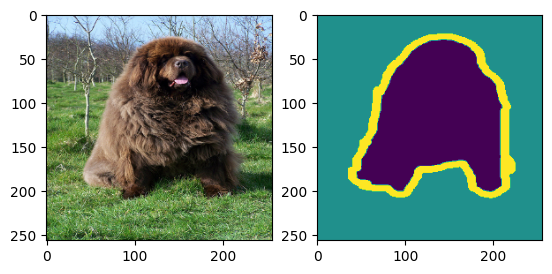

In [4]:
train_ds = MyDataset(train_imgs, train_trimaps)
test_ds = MyDataset(test_imgs, test_trimaps)

batch_size = 64
train_dl = data.DataLoader(train_ds, batch_size, shuffle=True)
test_dl = data.DataLoader(test_ds, batch_size)

imgs_batch, trimaps_batch = next(iter(train_dl))


plt.subplot(1,2,1)
plt.imshow(imgs_batch[0].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(trimaps_batch[0])

In [5]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, 
                 k_size=3, 
                 stride=1, 
                 pad=1):
        super(ConvBlock, self).__init__()
        self.conv_relu = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, 
                                      kernel_size=k_size,
                                      stride=stride,
                                      padding=pad),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True)
            )
    def forward(self, x):
        x = self.conv_relu(x)
        return x
    
class DeconvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, 
                 k_size=3, 
                 stride=2, 
                 pad=1,
                 padding=1):
        super(DeconvBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, 
                                            kernel_size=k_size,
                                            stride=stride,
                                            padding=padding,
                                            output_padding=pad)
        self.bn = nn.BatchNorm2d(out_channels)
            
    def forward(self, x, is_act=True):
        x = self.deconv(x)
        if is_act:
            x = torch.relu(self.bn(x))
        return x
    
class EncodeBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncodeBlock, self).__init__()
        self.conv1_1 = ConvBlock(in_channels, out_channels, stride=2)
        self.conv1_2 = ConvBlock(out_channels, out_channels)
        self.conv2_1 = ConvBlock(out_channels, out_channels)
        self.conv2_2 = ConvBlock(out_channels, out_channels)
        self.shortcut = ConvBlock(in_channels, out_channels, stride=2)

    def forward(self, x):
        out1 = self.conv1_1(x)
        out1 = self.conv2_1(out1)
        residue = self.shortcut(x)
        out2 = self.conv2_1(out1 + residue)
        out2 = self.conv2_2(out2)
        return out2 + out1
    
class DecodeBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecodeBlock, self).__init__()
        self.conv1 = ConvBlock(in_channels, in_channels//4, 
                               k_size=1, pad=0)
        self.deconv = DeconvBlock(in_channels//4, in_channels//4)
        self.conv2 = ConvBlock(in_channels//4, out_channels, 
                               k_size=1, pad=0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)
        return x

In [6]:
class LinknetModel(nn.Module):
    def __init__(self):
        super(LinknetModel, self).__init__()
        self.init_conv = ConvBlock(3, 64, 
                                   k_size=7, 
                                   stride=2,
                                   pad=3)
        self.init_maxpool = nn.MaxPool2d(kernel_size=(2, 2))
        
        self.encode1 = EncodeBlock(64, 64)
        self.encode2 = EncodeBlock(64, 128)
        self.encode3 = EncodeBlock(128, 256)
        self.encode4 = EncodeBlock(256, 512)
        
        self.decode4 = DecodeBlock(512, 256)
        self.decode3 = DecodeBlock(256, 128)
        self.decode2 = DecodeBlock(128, 64)
        self.decode1 = DecodeBlock(64, 64)
        
        self.deconv_last1 = DeconvBlock(64, 32)
        self.conv_last = ConvBlock(32, 32)
        self.deconv_last2 = DeconvBlock(32, 3, 
                                        k_size=2,
                                        pad=0,
                                        padding=0)
    
    def forward(self, x):
        x = self.init_conv(x)              #  (6, 128, 128, 64)
        x = self.init_maxpool(x)           #  (6, 64, 64, 64)
        
        e1 = self.encode1(x)               #  (6, 32, 32, 64)
        e2 = self.encode2(e1)              #  (6, 16, 16, 128)
        e3 = self.encode3(e2)              #  (6, 8, 8, 256)
        e4 = self.encode4(e3)              #  (6, 4, 4, 512)        
        
        d4 = self.decode4(e4) + e3
        d3 = self.decode3(d4) + e2
        d2 = self.decode2(d3) + e1
        d1 = self.decode1(d2)
        
        f1 = self.deconv_last1(d1)
        f2 = self.conv_last(f1)
        f3 = self.deconv_last2(f2, is_act=False)
        
        return f3

In [7]:
model = LinknetModel().cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [8]:
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    
    model.train()
    for x, y in trainloader:
        if torch.cuda.is_available():
            x, y = x.to('cuda'), y.to('cuda')
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
    exp_lr_scheduler.step()
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / (total*256*256)
        
        
    test_correct = 0
    test_total = 0
    test_running_loss = 0 
    
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / (test_total*256*256)
    
        
    print('epoch: ', epoch, 
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
             )
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [9]:
epochs = 30
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dl,
                                                                 test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.012 accuracy: 0.688 test_loss：  0.01 test_accuracy: 0.764
epoch:  1 loss：  0.008 accuracy: 0.814 test_loss：  0.009 test_accuracy: 0.789
epoch:  2 loss：  0.006 accuracy: 0.84 test_loss：  0.013 test_accuracy: 0.694
epoch:  3 loss：  0.006 accuracy: 0.856 test_loss：  0.007 test_accuracy: 0.834
epoch:  4 loss：  0.005 accuracy: 0.868 test_loss：  0.007 test_accuracy: 0.83
epoch:  5 loss：  0.005 accuracy: 0.875 test_loss：  0.007 test_accuracy: 0.844
epoch:  6 loss：  0.005 accuracy: 0.879 test_loss：  0.01 test_accuracy: 0.754
epoch:  7 loss：  0.004 accuracy: 0.897 test_loss：  0.008 test_accuracy: 0.823
epoch:  8 loss：  0.004 accuracy: 0.903 test_loss：  0.008 test_accuracy: 0.82
epoch:  9 loss：  0.004 accuracy: 0.905 test_loss：  0.008 test_accuracy: 0.829
epoch:  10 loss：  0.004 accuracy: 0.908 test_loss：  0.008 test_accuracy: 0.827
epoch:  11 loss：  0.004 accuracy: 0.909 test_loss：  0.01 test_accuracy: 0.8
epoch:  12 loss：  0.004 accuracy: 0.912 test_loss：  0.008 test_accurac

In [10]:
test_imgs_batch,test_trimaps_batch = next(iter(test_dl))

pred_imgs = model(test_imgs_batch.cuda())

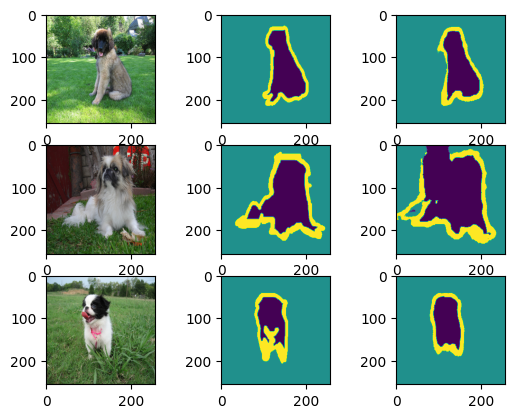

In [12]:
num = 3
for i in range(num):
    plt.subplot(num, 3, i*num+1)
    plt.imshow(test_imgs_batch[i].permute(1,2,0).cpu())
    plt.subplot(num, 3, i*num+2)
    plt.imshow(test_trimaps_batch[i].cpu()) # 两个像素图像之前预处理过
    plt.subplot(num, 3, i*num+3)
    # 对channels取最大值的位置对应黑白像素，取实际值data
    plt.imshow(torch.argmax(pred_imgs[i].permute(1,2,0), axis=-1).detach().cpu())